# Ingest phosim images with Gen3 butler

Stack release: **2021_13**
Last verified to run: **2021-04-01**

This ticket (https://jira.lsstcorp.org/browse/DM-29356) is an extension of DM-28341 . 

We demonstrate that we can ingest three  types of images into Gen3 butler:  lsstcam, corner sensors, and comcam. 
    
Lsstcam and corner sensors correspond to one instrument, called `lsst` in phosim, using geometry files from `data/lsst`. 

Comcam is a separate instrument (with only one raft R22, ITL), and is called `comcam` in phosim, using geometry files from `data/comcam`

All simulation is done on `lsst-devl03` (where phosim was configured ):
    
    ssh scichris@lsst-login01.ncsa.illinois.edu 
    ssh lsst-devl03 
    source "/software/lsstsw/stack/loadLSST.bash"    # need that for python 
    setup lsst_distrib 
    
    

The images are stored in subdirectories of `/project/scichris/aos/images/`

In [1]:
from lsst.daf import butler as dafButler
import lsst.afw.cameraGeom.utils as cameraGeomUtils
import lsst.afw.display as afwDisplay
import matplotlib.pyplot as plt
from matplotlib import rcParams 
from astropy.io import fits
from astropy.visualization import ZScaleInterval

import numpy as np 
import os 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

# 1) lsstCam data (single R22 E2V raft) 

Generate the simulated files:


    cd /project/scichris/aos/images/lsstCam

    python /project/scichris/aos/phosim_syseng4/phosim.py /project/scichris/aos/images/lsstCam/R22_letterF.inst -i lsst -e 1 -c /project/scichris/aos/images/lsstCam/noBkgnd.cmd -p 25 -o /project/scichris/aos/images/lsstCam/letter_R22/raw/ > starPhoSimLetter.log 2>&1

Repackage lsstCam data :

    setup -k -r /project/scichris/aos/phosim_utils/  # to be able to use the repackager


    phosim_repackager.py /project/scichris/aos/images/lsstCam/letter_R22/raw/ --out_dir /project/scichris/aos/images/lsstCam/letter_R22/repackaged/--inst lsst 


Ingest lsstCam data (I ingest only a single raft for illustration):

    butler create DATA
    butler register-instrument DATA/ lsst.obs.lsst.LsstCam
    butler ingest-raws DATA /project/scichris/aos/images/lsstCam/letter_R22/repackaged/

    butler define-visits DATA/ lsst.obs.lsst.LsstCam
    butler write-curated-calibrations DATA/ lsst.obs.lsst.LsstCam
    
Use this pipeline stored in `testPipeline.yaml` : 

    description: ISR basic processing pipeline
    instrument: lsst.obs.lsst.LsstCam
    tasks:
      isr:
        class: lsst.ip.isr.isrTask.IsrTask
        config:
          connections.outputExposure: 'postISRCCD'
          doBias: False
          doVariance: False
          doLinearize: False
          doCrosstalk: False
          doDefect: False
          doNanMasking: False
          doInterpolate: False
          doBrighterFatter: False
          doDark: False
          doFlat: False
          doApplyGains: True
          doFringe: False
          doOverscan: True
          
Run the ISR task:

    pipetask run -j 9 -b DATA/ -i LSSTCam/raw/all,LSSTCam/calib -p testPipeline.yaml --register-dataset-types --output-run run1

Inspect the Gen3 repo:

In [2]:
path_to_repo = '/project/scichris/aos/images/lsstCam/letter_R22/DATA/'
butler = dafButler.Butler(path_to_repo)

registry = butler.registry
dataTypes = registry.queryDatasetTypes()
for dataType in dataTypes:
    print(dataType)
    

for x in registry.queryCollections():
    print(x)
    
datasetRefs = list(registry.queryDatasets(datasetType='postISRCCD', collections=['run1']))
for ref in datasetRefs:
    print(ref.dataId)
    print(ref.dataId.keys())   

DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
DatasetType('camera', {instrument}, Camera, isCalibration=True)
DatasetType('postISRCCD', {band, instrument, detector, physical_filter, exposure}, Exposure)
DatasetType('isr_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
DatasetType('isr_config', {}, Config)
DatasetType('packages', {}, Packages)
LSSTCam/raw/all
LSSTCam/calib
LSSTCam/calib/unbounded
run1
{instrument: 'LSSTCam', detector: 90, exposure: 4016091606002, ...}
{instrument, detector, exposure}
{instrument: 'LSSTCam', detector: 95, exposure: 4016091606002, ...}
{instrument, detector, exposure}
{instrument: 'LSSTCam', detector: 92, exposure: 4016091606002, ...}
{instrument, detector, exposure}
{instrument: 'LSSTCam', detector: 91, exposure: 4016091606002, ...}
{instrument, detector, exposure}
{instrument: 'LSSTCam', detector: 94, exposure: 4016091606002, ...}
{instrument, detector, exposure}
{instrument: 'LSSTC

Show the postISR image:

Text(0.5, 1.0, 'LsstCam, R22_S00')

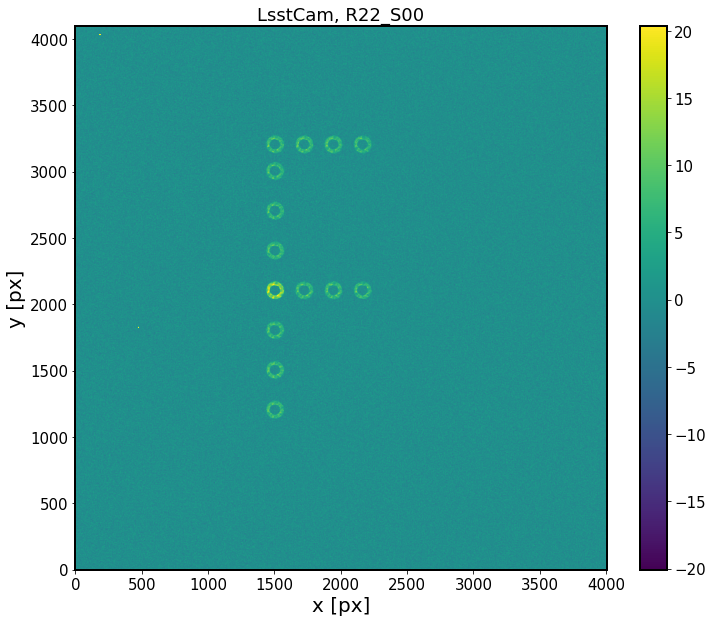

In [3]:
%matplotlib inline

exposure = butler.get('postISRCCD', dataId=datasetRefs[0].dataId, collections=['run1'])
detector = exposure.getDetector()
data = exposure.image.array
zscale = ZScaleInterval()
vmin, vmax = zscale.get_limits(data)

fig = plt.figure(figsize=(12, 10))

plt.imshow(data.T, origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.title(f'LsstCam, {detector.getName()}')

Show which channels are used: 

In [4]:
def plot_raw_lsstCam_channels(hdul):
    amp_dic = {}
    for i in range(1,len(hdul)):
        amp_dic[hdul[i].header['AMPID']]=i   
    
    fig,ax = plt.subplots(8,2, figsize=(2*4.096, 2*4.608))

    # plot left hand side column
    amps = ['C00','C01','C02','C03','C04','C05','C06','C07']
    column = 0
    row = 0
    for amp in amps[::-1]:
        hdu = hdul[amp_dic[amp]]
        ax[row,column].imshow(hdu.data.T, origin='lower')
        ax[row,column].set(yticklabels=[],xticklabels=[])
        ax[row,column].tick_params(left=False, bottom=False)
        ax[row,column].set_frame_on(False)
        ax[row,column].text(200,200,amp,fontsize=15)
        row += 1    
    
    # plot right hand side column
    amps = ['C10','C11','C12','C13','C14','C15','C16','C17']
    column = 1
    row = 0 
    for amp in amps[::-1]:
        hdu = hdul[amp_dic[amp]]
        ax[row,column].imshow(np.fliplr(np.flipud(hdu.data.T)), origin='lower')
        ax[row,column].set(yticklabels=[],xticklabels=[])
        ax[row,column].tick_params(left=False, bottom=False)
        ax[row,column].set_frame_on(False)
        ax[row,column].text(200,200,amp, fontsize=15)
        row += 1 

    # add a horizontal arrow 
    bbox_props = dict(boxstyle="rarrow,pad=0.2", fc="orange", 
                      ec="b", alpha=1.0, lw=1, clip_on = True,
                      )
    n_spaces = 30 
    t = ax[7,1].text(0.5, -0.1, n_spaces*' '+'x [px]'+n_spaces*' ', 
                     ha="center", va="center", rotation=0, size=15, 
                     bbox=bbox_props)
    raft,sensor = hdul[0].header['RAFTBAY'], hdul[0].header['CCDSLOT']
    instrument = hdul[0].header['INSTRUME']
    fig.suptitle(f"{instrument}: {raft}_{sensor}, raw channels", fontsize=18)
    plt.subplots_adjust(hspace=0, wspace=-0.04)


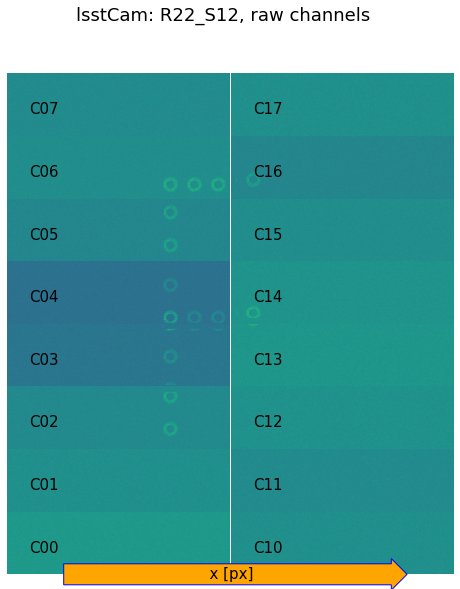

In [5]:
path_to_raw = '/project/scichris/aos/images/lsstCam/letter_R22/repackaged/MC_H_20160916_006002_R22_S12.fits'
hdul = fits.open(path_to_raw)

plot_raw_lsstCam_channels(hdul)

# 2) lsstCam data (corner rafts)

Generate:
    
    cd /project/scichris/aos/images/cornerSensors/
        
    python /project/scichris/aos/phosim_syseng4/phosim.py /project/scichris/aos/images/cornerSensors/starArrowsLetters.inst -i lsst -e 1 -c /project/scichris/aos/images/cornerSensors/noBkgnd.cmd -p 25 -o /project/scichris/aos/images/cornerSensors/arrowsLetters/raw/ > starPhoSim.log 2>&1

Repackage

    phosim_repackager.py /project/scichris/aos/images/cornerSensors/arrowsLetters/raw/ --out_dir /project/scichris/aos/images/cornerSensors/arrowsLetters/repackaged/

Ingest and ISR  lsstCam  corner raft data (I ingest only a  single raft for illustration):

    
    butler create DATA
    butler register-instrument DATA/ lsst.obs.lsst.LsstCam
    butler ingest-raws DATA /project/scichris/aos/images/cornerSensors/arrowsLetters/repackaged/

    butler define-visits DATA/ lsst.obs.lsst.LsstCam
    butler write-curated-calibrations DATA/ lsst.obs.lsst.LsstCam
    
Use this pipeline stored in `testPipeline.yaml` : 

    description: ISR basic processing pipeline
    instrument: lsst.obs.lsst.LsstCam
    tasks:
      isr:
        class: lsst.ip.isr.isrTask.IsrTask
        config:
          connections.outputExposure: 'postISRCCD'
          doBias: False
          doVariance: False
          doLinearize: False
          doCrosstalk: False
          doDefect: False
          doNanMasking: False
          doInterpolate: False
          doBrighterFatter: False
          doDark: False
          doFlat: False
          doApplyGains: True
          doFringe: False
          doOverscan: True
          
Run the ISR task:

    pipetask run -j 9 -b DATA/ -i LSSTCam/raw/all,LSSTCam/calib -p testPipeline.yaml --register-dataset-types --output-run run1

Inspect the gen3 repository:

In [6]:
path_to_repo = '/project/scichris/aos/images/cornerSensors/arrowsLetters/DATA/'
butler = dafButler.Butler(path_to_repo)

registry = butler.registry
dataTypes = registry.queryDatasetTypes()
for dataType in dataTypes:
    print(dataType)
    

for x in registry.queryCollections():
    print(x)
    
datasetRefs = list(registry.queryDatasets(datasetType='postISRCCD', collections=['run1']))
for ref in datasetRefs:
    print(ref.dataId)
    print(ref.dataId.keys())   

DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
DatasetType('camera', {instrument}, Camera, isCalibration=True)
DatasetType('postISRCCD', {band, instrument, detector, physical_filter, exposure}, Exposure)
DatasetType('isr_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
DatasetType('isr_config', {}, Config)
DatasetType('packages', {}, Packages)
LSSTCam/raw/all
LSSTCam/calib
LSSTCam/calib/unbounded
run1
{instrument: 'LSSTCam', detector: 199, exposure: 4000021706002, ...}
{instrument, detector, exposure}
{instrument: 'LSSTCam', detector: 200, exposure: 4000021706002, ...}
{instrument, detector, exposure}
{instrument: 'LSSTCam', detector: 203, exposure: 4000021706002, ...}
{instrument, detector, exposure}
{instrument: 'LSSTCam', detector: 195, exposure: 4000021706002, ...}
{instrument, detector, exposure}
{instrument: 'LSSTCam', detector: 204, exposure: 4000021706002, ...}
{instrument, detector, exposure}
{instrument: '

Show the postISR image:

Text(0.5, 1.0, 'LsstCam, R44_SW1')

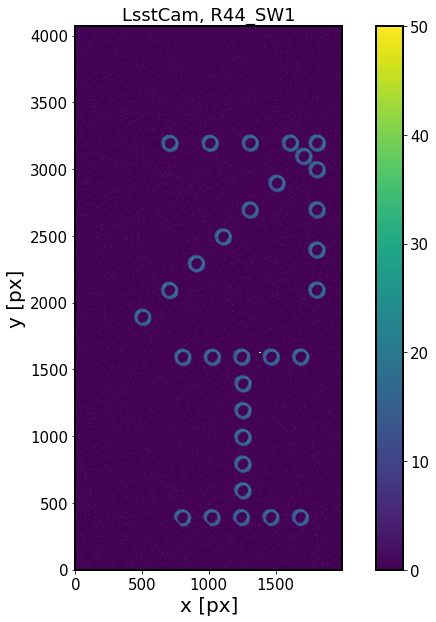

In [7]:
%matplotlib inline
exposure= butler.get('postISRCCD', dataId=datasetRefs[4].dataId, collections=['run1'])
detector = exposure.getDetector()
fig = plt.figure(figsize=(12, 10))
plt.imshow(exposure.image.array.T, origin='lower',vmin=0, vmax=50)
plt.colorbar()
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.title(f'LsstCam, {detector.getName()}')

Show the locations of individual channels by manually assembling the raw image:

In [8]:
path_to_raw = '/project/scichris/aos/images/cornerSensors/arrowsLetters/repackaged/MC_H_20000217_006002_R44_SW1.fits'
hdul = fits.open(path_to_raw)

amp_dic = {}
for i in range(1,len(hdul)):
    amp_dic[hdul[i].header['AMPID']]=i    

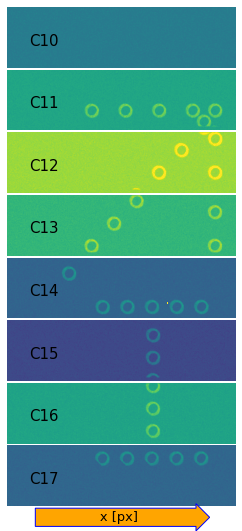

In [9]:
fig,ax = plt.subplots(8,1, figsize=(4.096, 2*4.608))

column = 0
row = 0
for amp in amp_dic.keys():
    hdu = hdul[amp_dic[amp]]
    ax[row].imshow(np.fliplr(np.flipud(hdu.data.T)), origin='lower', vmin=950,vmax=1050)
    ax[row].set(yticklabels=[],xticklabels=[])
    ax[row].tick_params(left=False, bottom=False)
    ax[row].set_frame_on(False)
    ax[row].text(200,200,amp, fontsize=15)
    row += 1    

# horizontal arrow 
bbox_props = dict(boxstyle="rarrow,pad=0.2", fc="orange", 
                  ec="b", alpha=1.0, lw=1, clip_on = True,
                  )
n_spaces = 15 
t = ax[7].text(1000, -100, n_spaces*' '+'x [px]'+n_spaces*' ', 
                 ha="center", va="center", rotation=0, size=13, 
                 bbox=bbox_props)

plt.subplots_adjust(hspace=0, wspace=-0.04)



Show the assembly of all the corner rafts:

In [10]:
afwDisplay.setDefaultBackend("matplotlib")

repo_dir = os.path.join('/project/scichris/aos/images/cornerSensors/arrowsLetters/DATA/')

# need to specify the calib collections to be able to access the camera 
instrument = 'LSSTCam'
butler = dafButler.Butler(repo_dir, collections=[f'{instrument}/raw/all',
                                                 f'{instrument}/calib','run1',
                                                 f'{instrument}/calib/unbounded']
                         )

dataId0 = dict(instrument=instrument)
dataset = next(iter(
                    butler.registry.queryDatasets(
                        datasetType='postISRCCD', 
                        collections=['run1'],
                        dataId=dataId0  )
                    )
               )

exposure = dataset.dataId["exposure"]

camera  = butler.get("camera", instrument=instrument, exposure=exposure)

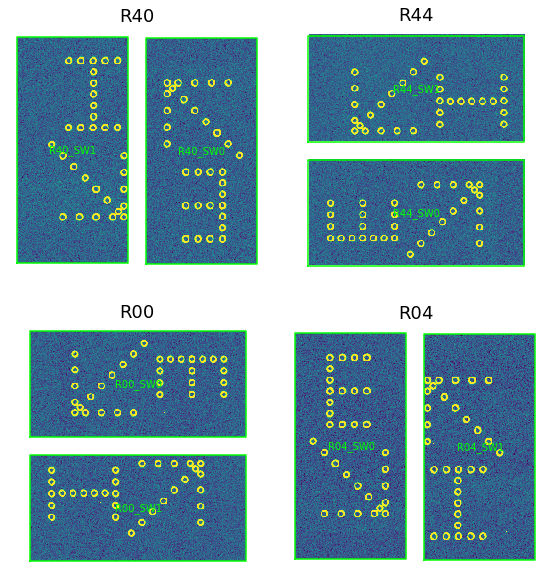

In [11]:
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.2, wspace=0.0, )

disp = afwDisplay.Display(fig)
disp.scale('asinh', 'zscale', Q=2)

disp.setImageColormap('viridis' if True else 'gray')
dataType = "postISRCCD"

detectorNameLists = [['R40_SW0', 'R40_SW1'],
                     ['R44_SW0', 'R44_SW1'],
                     ['R00_SW0', 'R00_SW1'],
                     ['R04_SW0', 'R04_SW1']
                    ]
i = 1
for detectorNameList in detectorNameLists:
    
    ax = fig.add_subplot(2, 2, i)

    raftName = detectorNameList[0][:3]
    mos = cameraGeomUtils.showCamera(camera,
                                 cameraGeomUtils.ButlerImage(butler, dataType, 
                                                             instrument=instrument, 
                                                             exposure=exposure,
                                                             verbose=True),
                                 binSize=16, 
                                 detectorNameList=detectorNameList, 
                                 display=disp, overlay=True,
                                 title=raftName,)
    disp.show_colorbar(False)
    ax.axis("off")
    
    i += 1 

The arrow for R44_SW1 points towards the field center (R22). 

# 3) comCam data (single  R22 ITL raft )

Generate data 

      python /project/scichris/aos/phosim_syseng4/phosim.py /project/scichris/aos/images/comCam/R22_letterF.inst -i comcam -e 1 -c /project/scichris/aos/images/comCam/noBkgnd.cmd -p 25 -o /project/scichris/aos/images/comCam/letter/raw/ > starPhoSimLetter.log 2>&1

Repackage

    phosim_repackager.py /project/scichris/aos/images/comCam/letter/raw/ --out_dir /project/scichris/aos/images/comCam/letter/repackaged/ --inst comcam


Ingest and ISR  comCam data:
    
    cd /project/scichris/aos/images/comCam/letter/
    
    butler create DATA
    butler register-instrument DATA/ lsst.obs.lsst.LsstComCam
    butler ingest-raws DATA /project/scichris/aos/images/comCam/letter/repackaged/

    butler define-visits DATA/ lsst.obs.lsst.LsstComCam
    butler write-curated-calibrations DATA/ lsst.obs.lsst.LsstComCam
    
Use this pipeline stored in `testPipeline.yaml` : 

    description: ISR basic processing pipeline
    instrument: lsst.obs.lsst.LsstComCam
    tasks:
      isr:
        class: lsst.ip.isr.isrTask.IsrTask
        config:
          connections.outputExposure: 'postISRCCD'
          doBias: False
          doVariance: False
          doLinearize: False
          doCrosstalk: False
          doDefect: False
          doNanMasking: False
          doInterpolate: False
          doBrighterFatter: False
          doDark: False
          doFlat: False
          doApplyGains: True
          doFringe: False
          doOverscan: True
          
Run the ISR task:

    pipetask run -j 9 -b DATA/ -i LSSTComCam/raw/all,LSSTComCam/calib -p testPipeline.yaml --register-dataset-types --output-run run1

Explore the content of the butler repository:

In [12]:
path_to_repo = '/project/scichris/aos/images/comCam/letter/DATA/'
butler = dafButler.Butler(path_to_repo)

registry = butler.registry
dataTypes = registry.queryDatasetTypes()
for dataType in dataTypes:
    print(dataType)
    

for x in registry.queryCollections():
    print(x)
    
datasetRefs = list(registry.queryDatasets(datasetType='postISRCCD', collections=['run1']))
for ref in datasetRefs:
    print(ref.dataId)
    print(ref.dataId.keys())   

DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
DatasetType('camera', {instrument}, Camera, isCalibration=True)
DatasetType('postISRCCD', {band, instrument, detector, physical_filter, exposure}, Exposure)
DatasetType('isr_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
DatasetType('isr_config', {}, Config)
DatasetType('packages', {}, Packages)
LSSTComCam/raw/all
LSSTComCam/calib
LSSTComCam/calib/unbounded
run1
{instrument: 'LSSTComCam', detector: 8, exposure: 4016091606002, ...}
{instrument, detector, exposure}
{instrument: 'LSSTComCam', detector: 4, exposure: 4016091606002, ...}
{instrument, detector, exposure}
{instrument: 'LSSTComCam', detector: 5, exposure: 4016091606002, ...}
{instrument, detector, exposure}
{instrument: 'LSSTComCam', detector: 7, exposure: 4016091606002, ...}
{instrument, detector, exposure}
{instrument: 'LSSTComCam', detector: 1, exposure: 4016091606002, ...}
{instrument, detector, exposure}


Show the postISR image for a single sensor:

Text(0.5, 1.0, 'LsstComCam, R22_S12 (ITL)')

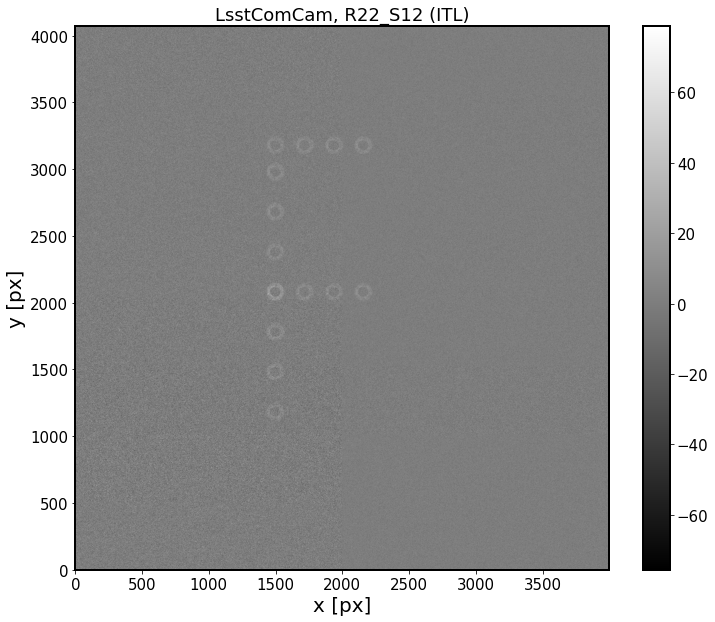

In [13]:
%matplotlib inline

exposure = butler.get('postISRCCD', dataId=datasetRefs[2].dataId, collections=['run1'])
detector = exposure.getDetector()
data = exposure.image.array
vmin, vmax = zscale.get_limits(data)

fig = plt.figure(figsize=(12, 10))
plt.imshow(data.T, origin='lower', vmin=vmin,vmax=vmax,cmap='gray')
plt.colorbar()
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.title(f'LsstComCam, {detector.getName()} (ITL)')

Show the raw channels orientation. There is a vertical split between C0x and C1x channels, with C00 at the bottom left and C10 at the bottom right:

In [14]:
def plot_raw_lsstComCam_channels(hdul):
    amp_dic = {}
    for i in range(1,len(hdul)):
        amp_dic[hdul[i].header['AMPID']]=i   
    
    fig,ax = plt.subplots(8,2, figsize=(2*4.0, 2*4.072))

    # plot left hand side column
    amps = ['C00','C01','C02','C03','C04','C05','C06','C07']
    column = 0
    row = 0
    for amp in amps[::-1]:
        hdu = hdul[amp_dic[amp]]
        ax[row,column].imshow(np.flipud(hdu.data.T), origin='lower',
                             )
        ax[row,column].set(yticklabels=[],xticklabels=[])
        ax[row,column].tick_params(left=False, bottom=False)
        ax[row,column].set_frame_on(False)
        ax[row,column].text(200,200,amp, fontsize=15)
        row += 1    
    
    # plot right hand side column
    amps = ['C10','C11','C12','C13','C14','C15','C16','C17']
    column = 1
    row = 0 
    for amp in amps[::-1]:
        hdu = hdul[amp_dic[amp]]
        ax[row,column].imshow(np.fliplr(np.flipud(hdu.data.T)), origin='lower')
        ax[row,column].set(yticklabels=[],xticklabels=[])
        ax[row,column].tick_params(left=False, bottom=False)
        ax[row,column].set_frame_on(False)
        ax[row,column].text(200,200,amp, fontsize=15)
        row += 1 

    # add a horizontal arrow 
    bbox_props = dict(boxstyle="rarrow,pad=0.2", fc="orange", 
                      ec="b", alpha=1.0, lw=1, clip_on = True,
                      )
    n_spaces = 30 
    t = ax[7,1].text(0.5, -0.1, n_spaces*' '+'x [px]'+n_spaces*' ', 
                     ha="center", va="center", rotation=0, size=15, 
                     bbox=bbox_props)
    raft,sensor = hdul[0].header['RAFTBAY'], hdul[0].header['CCDSLOT']
    instrument = hdul[0].header['INSTRUME']
    fig.suptitle(f"{instrument}: {raft}_{sensor}, raw channels", fontsize=18)
    plt.subplots_adjust(hspace=-0.05, wspace=0)


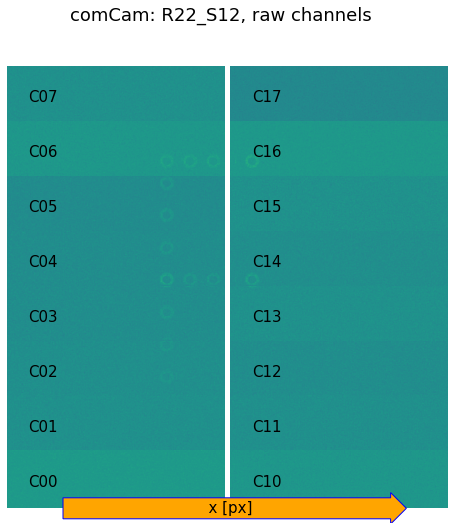

In [15]:
path_to_raw = '/project/scichris/aos/images/comCam/letter/repackaged/CC_H_20160916_006002_R22_S12.fits'
hdul = fits.open(path_to_raw)
plot_raw_lsstComCam_channels(hdul)


Show all the comCam sensors using `afwCameraGeom` : 

In [16]:
afwDisplay.setDefaultBackend("matplotlib")
repo_dir = os.path.join('/project/scichris/aos/images/comCam/letter/DATA/')

# need to specify the calib collections to be able to access the camera 
instrument = 'LSSTComCam'
butler = dafButler.Butler(repo_dir, collections=[f'{instrument}/raw/all',
                                                 f'{instrument}/calib','run1',
                                                 f'{instrument}/calib/unbounded']
                         )


dataId0 = dict(instrument=instrument)
dataset = next(iter(
                    butler.registry.queryDatasets(
                        datasetType='postISRCCD', 
                        collections=['run1'],
                        dataId=dataId0  )
                    )
               )

exposure = dataset.dataId["exposure"]

camera  = butler.get("camera", instrument=instrument, exposure=exposure)

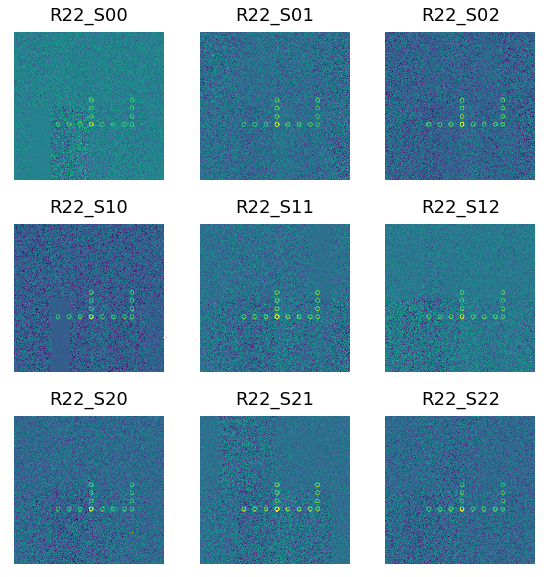

In [17]:
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.2, wspace=0.0, )

disp = afwDisplay.Display(fig)
disp.scale('asinh', 'zscale', Q=2)
#disp.scale('linear', 'minmax')
disp.setImageColormap('viridis' if True else 'gray')
dataType = "postISRCCD"

i = 1
for detector in camera:
    
    ax = fig.add_subplot(3, 3, i)
    
    mos = cameraGeomUtils.showCamera(camera,
                                 cameraGeomUtils.ButlerImage(butler, dataType, 
                                                             instrument=instrument, 
                                                             exposure=exposure,
                                                             verbose=True),
                                 binSize=16, 
                                 detectorNameList=[detector.getName()], 
                                 display=disp, overlay=False,
                                 title=detector.getName(),)
    disp.show_colorbar(False)
    ax.axis("off")
    
    i += 1 